# EVALUATE MODEL loading from disk

Evaluate DKPN..

-----------------------------------------------------------------

In [1]:
import os
import sys
import copy
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

import obspy

import torch
import seisbench as sb
import seisbench.models as sbm
import seisbench.data as sbd

import dkpn.core as dkcore
import dkpn.train as dktrain

import dkpn.eval_utils as EV

print(" SB version:  %s" % sb.__version__)
print("OBS version:  %s" % obspy.__version__)

 SB version:  0.4.0
OBS version:  1.4.0


In [9]:
# ============================================
DATASET_TRAIN = "ETHZ"
DATASET_TEST = "ETHZ"
DATASET_SIZE = "Nano"
RANDOM_SEED = 42

DKPN_MODEL_NAME = "DKPN_TrainDataSet_ETHZ_Size_Nano_Rnd_42_Epochs_2_LR_0.0100_Batch_10"
DKPN_MODEL_PATH = Path(DKPN_MODEL_NAME+"/"+DKPN_MODEL_NAME+".pt")

PN_MODEL_NAME = "PN_TrainDataSet_ETHZ_Size_Nano_Rnd_42_Epochs_2_LR_0.0100_Batch_20"
PN_MODEL_PATH = Path(PN_MODEL_NAME+"/"+PN_MODEL_NAME+".pt")

# ============================================

STORE_DIR_RESULTS = Path("TRAIN_TEST_RESULTS")
if not STORE_DIR_RESULTS.is_dir():
    STORE_DIR_RESULTS.mkdir()

# ============================================

PICKTHRESHOLD_P = 0.2
PICKTHRESHOLD_S = 0.2
PLOTS = True
NPLOTS = 5

TEST_SAMPLES = 5000
GORANDOM = True  # For test-sample selection

### SELECT DATASET and SIZE

Here you can decide to load the same dataset for _In-Domain_ tests, or a different one for _Cross-Domain_ testing.

In [5]:
(dataset_train, dataset_test) = dktrain.select_database_and_size(
                                    DATASET_TRAIN, DATASET_TEST, DATASET_SIZE, RANDOM_SEED=RANDOM_SEED)
train = dataset_train.train()
dev = dataset_train.dev()
test = dataset_test.test()

print("TRAIN samples %s:  %d" % (DATASET_TRAIN, len(train)))
print("  DEV samples %s:  %d" % (DATASET_TRAIN, len(dev)))
print(" TEST samples %s:  %d" % (DATASET_TEST, len(test)))

2023-06-08 17:01:52,040 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb


Selecting DATASET TRAIN/DEV: ETHZ
Selecting DATASET TEST:      ETHZ
Selecting DATASET SIZE:      NANO


2023-06-08 17:01:52,351 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb


TRAIN samples ETHZ:  734
  DEV samples ETHZ:  73
 TEST samples ETHZ:  35936


### INITIALIZE PICKERS

Here we make sure to have correctly loaded them with their defaults

In [10]:
# Print loading
print("Loading DKPN ... ")
mydkpn = dkcore.DKPN()
mydkpn.load_state_dict(torch.load(str(DKPN_MODEL_PATH), map_location=torch.device('cpu')))
# mydkpn.cuda();

print("Loading PN ... ")
mypn = sbm.PhaseNet()
mypn.load_state_dict(torch.load(str(PN_MODEL_PATH), map_location=torch.device('cpu')))

# =================================================================
# =================================================================
mydkpn.eval();
mypn.eval();
# =================================================================
# =================================================================


Loading DKPN ... 
Loading PN ... 


-------------------------------------------------------------------------------

# EVALUATING MODEL

Checking everything is OK and doing statistics using _5000 random samples_ extracted from the `test_generator`. But first, we need to **close** the MODEL before any prediction!
We need to define the TruePositive, FalsePositive, FalseNegative:

- **TP**: if a pick of the same label falls inside a 0.2 seconds 
- **FP**: if model declare a pick that doesn't have a match 
- **FN**: if there's a label but unseen by the model

The functions and indexes are contained in `dkpn.eval_utils.py`.
For consistency, we 

**NB: we need to set the flag `"for_what": "TEST"` !!**

In [11]:
# ========================  Getting / Instantiate class 
TRAIN_CLASS_DKPN = dktrain.TrainHelp_DomainKnowledgePhaseNet(
                mydkpn,  # It will contains the default args for StreamCF calculations!!!
                train,
                dev,
                test,

                augmentations_par = {
                    "amp_norm_type": "std",
                    "window_strategy": "move",  # "pad"
                    "final_windowlength": 3001,
                    "sigma": 10,
                    "phase_dict": {
                        "trace_p_arrival_sample": "P",
                        "trace_pP_arrival_sample": "P",
                        "trace_P_arrival_sample": "P",
                        "trace_P1_arrival_sample": "P",
                        "trace_Pg_arrival_sample": "P",
                        "trace_Pn_arrival_sample": "P",
                        "trace_PmP_arrival_sample": "P",
                        "trace_pwP_arrival_sample": "P",
                        "trace_pwPm_arrival_sample": "P",
                        "trace_s_arrival_sample": "S",
                        "trace_S_arrival_sample": "S",
                        "trace_S1_arrival_sample": "S",
                        "trace_Sg_arrival_sample": "S",
                        "trace_SmS_arrival_sample": "S",
                        "trace_Sn_arrival_sample": "S"
                    },
                })

# ========================  AUGMENTATIONS DKPN
(train_generator_dkpn, dev_generator_dkpn, test_generator_dkpn) = TRAIN_CLASS_DKPN.get_generator()


Working with:  TEST_DKPN + TEST_PN


  0%|                                                                                                                              | 0/10 [00:00<?, ?it/s]

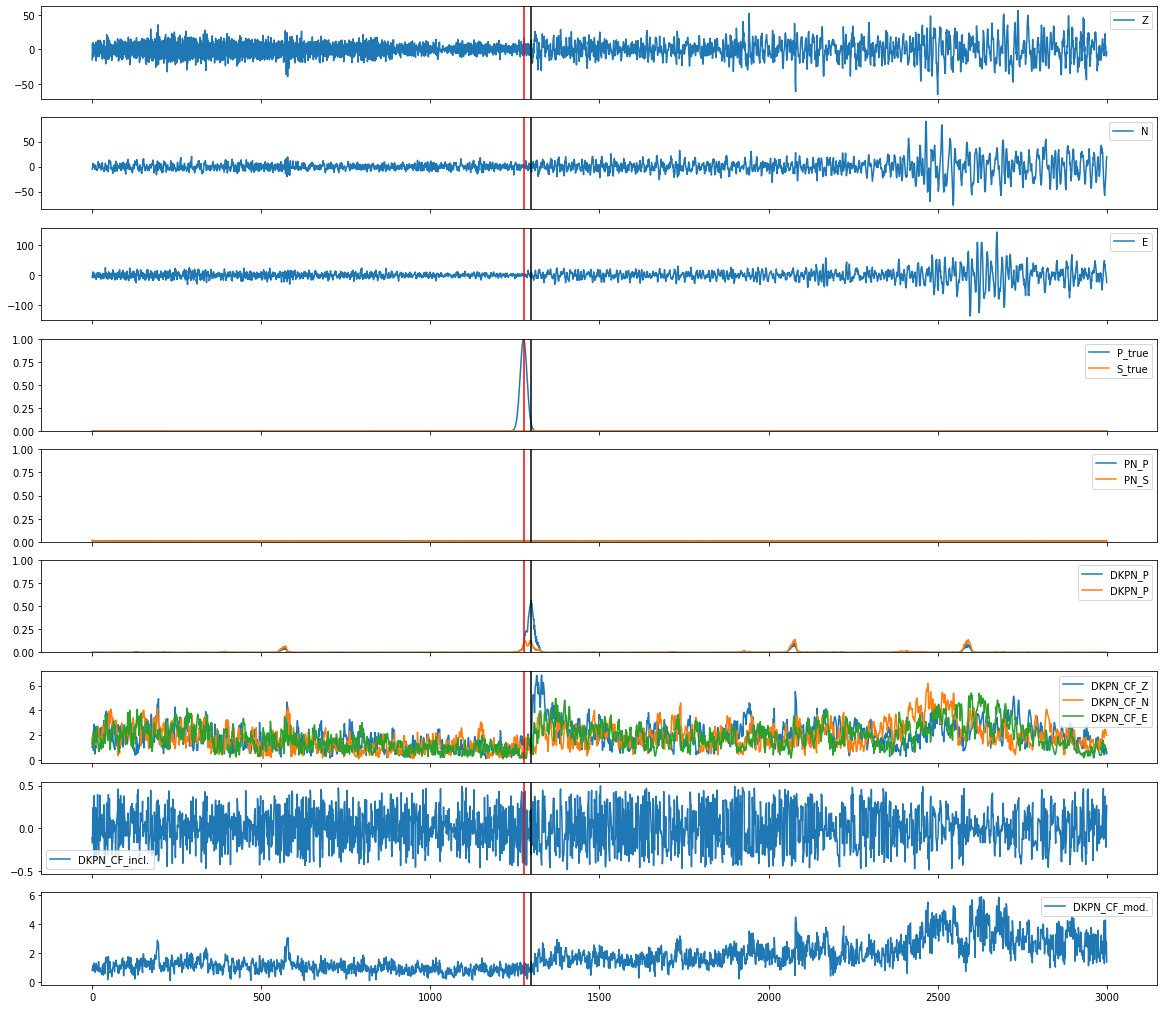

 10%|███████████▊                                                                                                          | 1/10 [00:01<00:11,  1.29s/it]

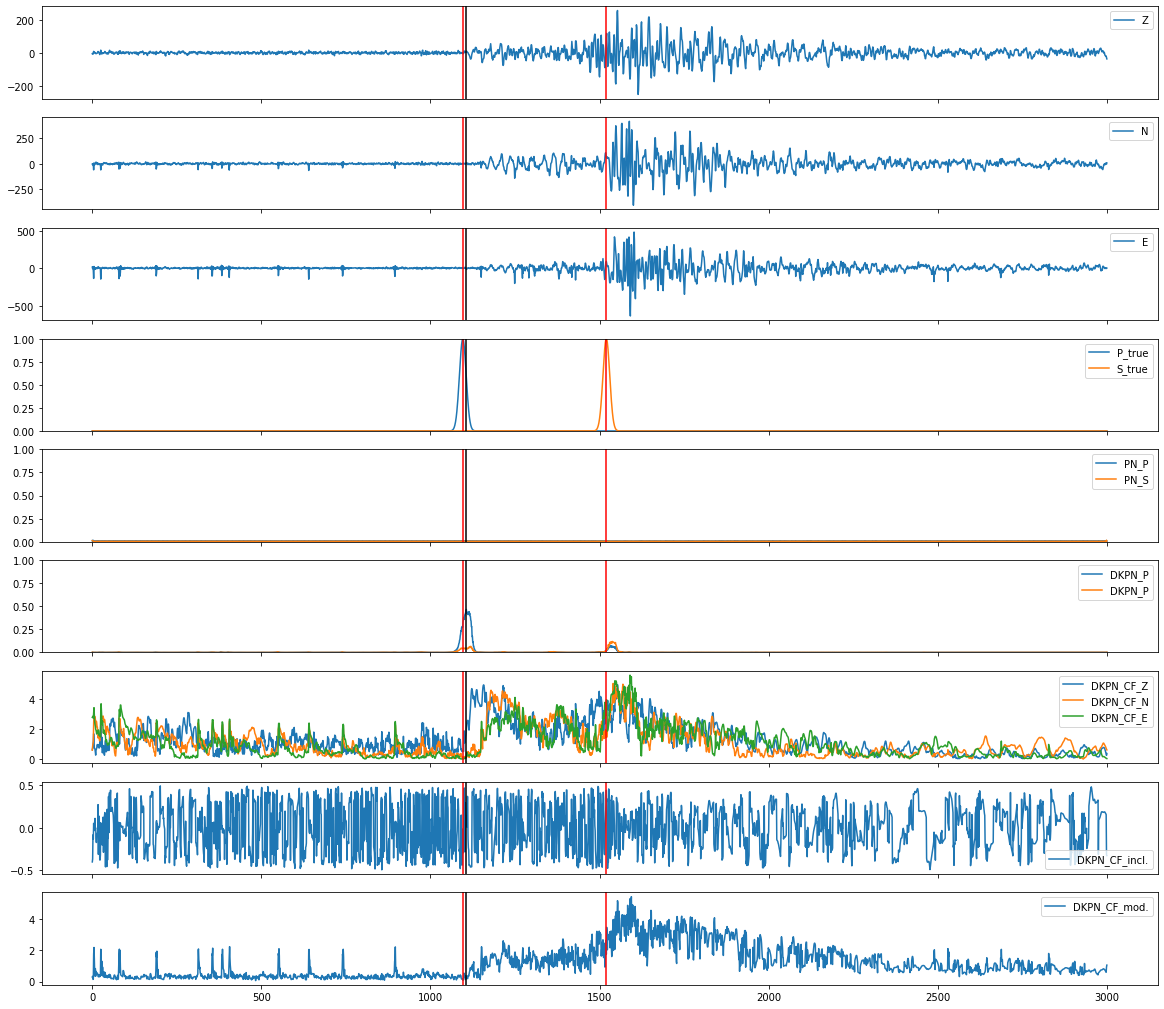

 20%|███████████████████████▌                                                                                              | 2/10 [00:02<00:10,  1.27s/it]

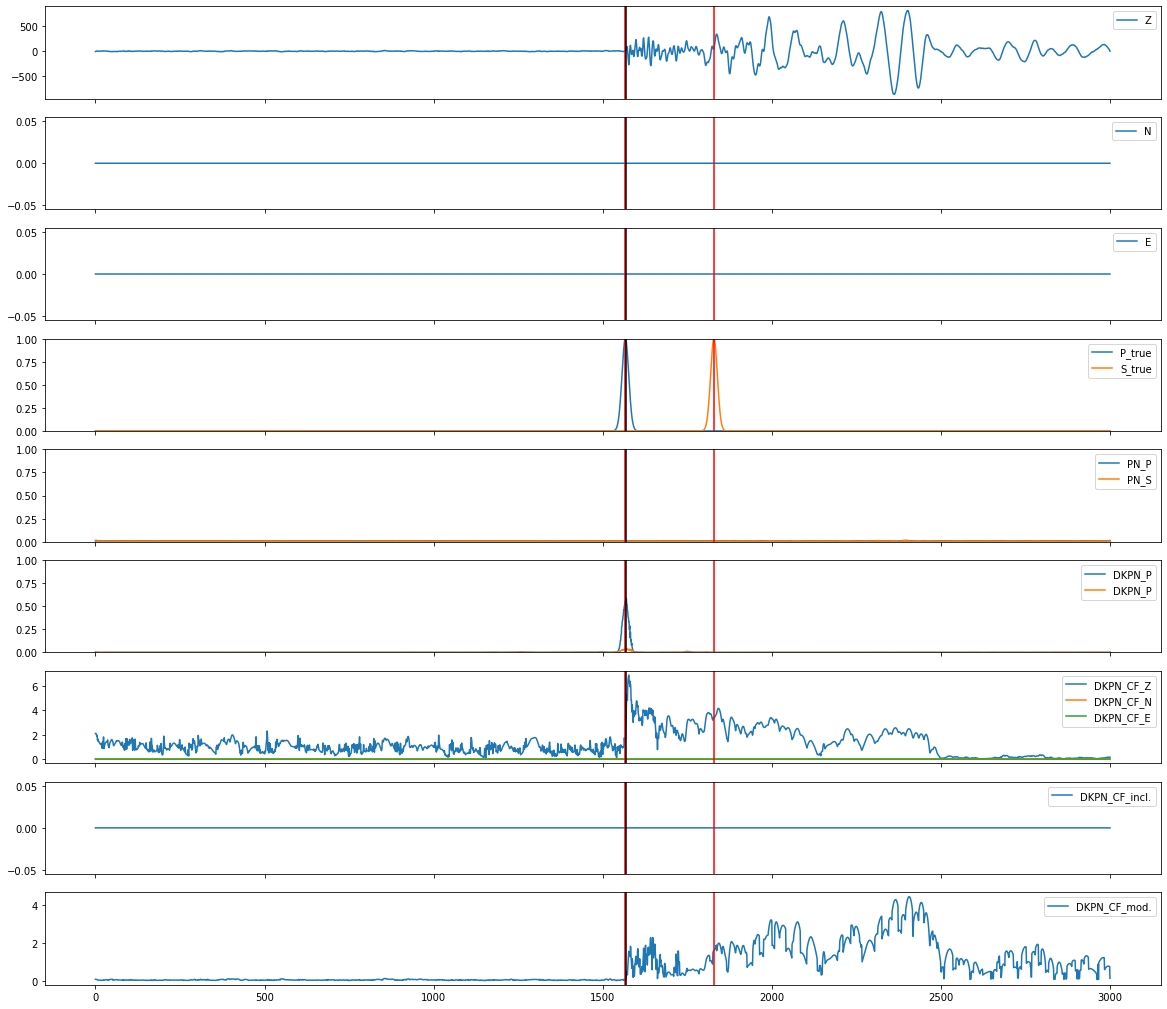

 30%|███████████████████████████████████▍                                                                                  | 3/10 [00:04<00:09,  1.36s/it]

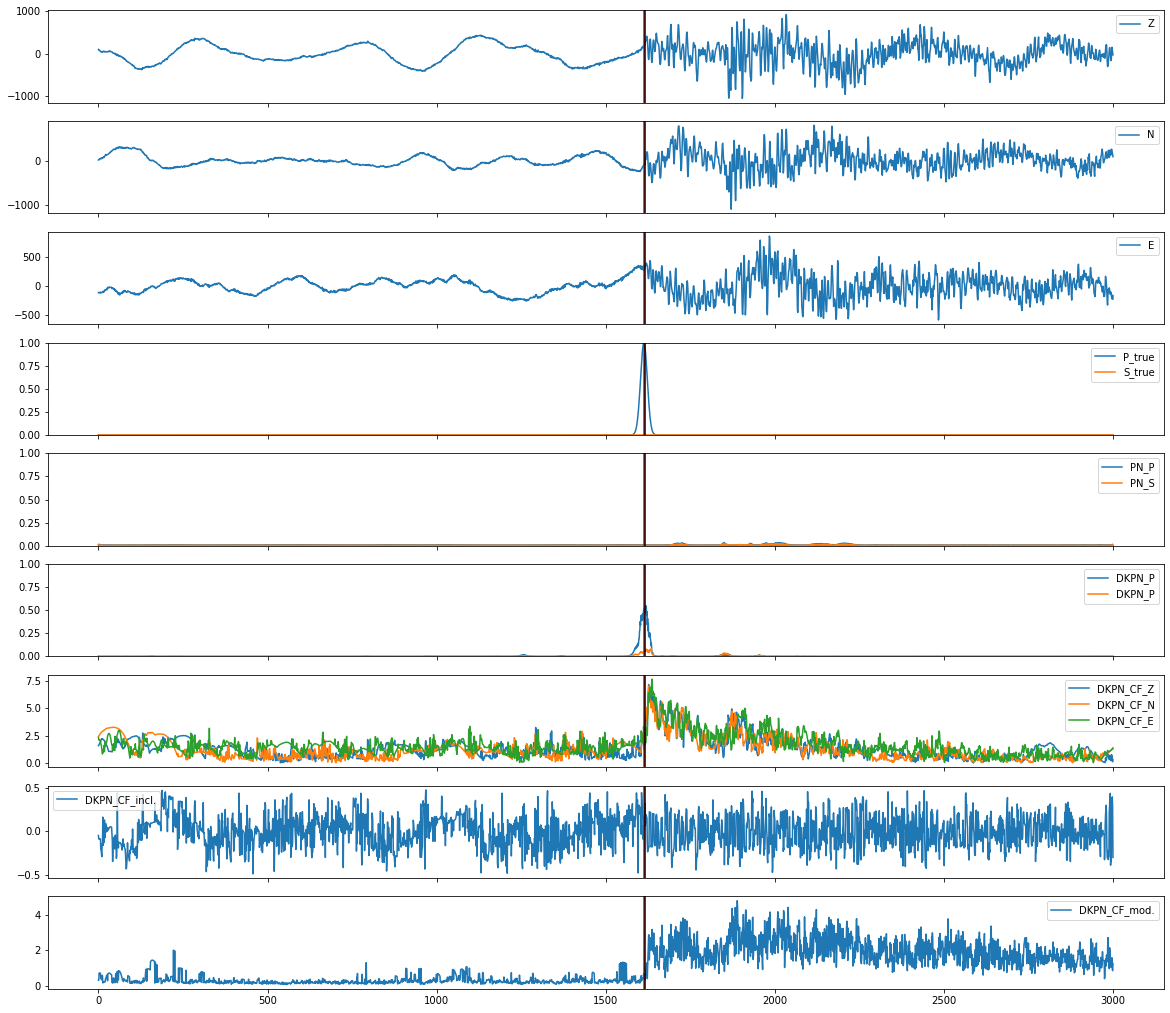

 40%|███████████████████████████████████████████████▏                                                                      | 4/10 [00:05<00:07,  1.28s/it]

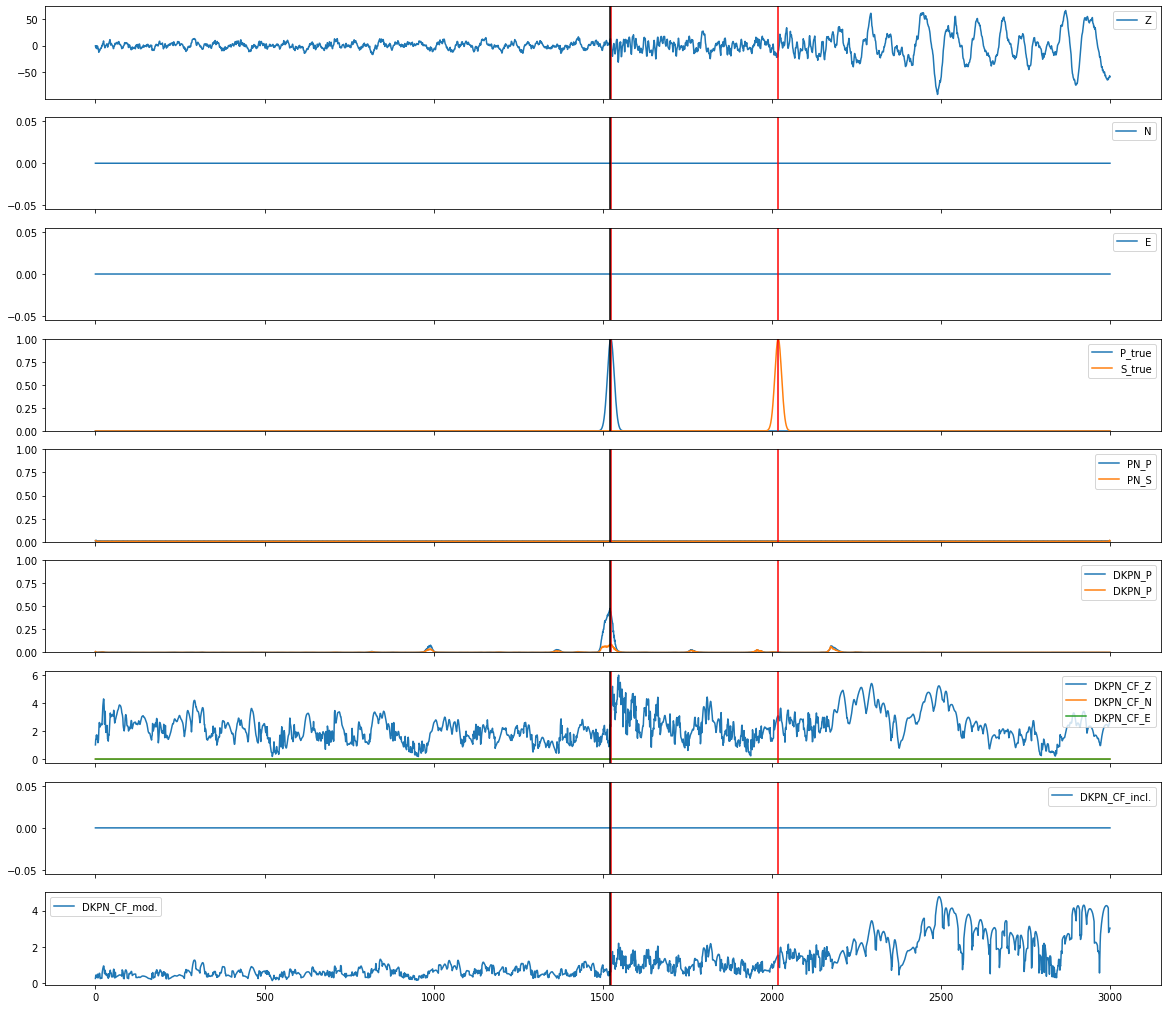

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.48it/s]
/homes/bagagli/.conda/envs/sometools_SBupdated/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/bagagli/.conda/envs/sometools_SBupdated/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/homes/bagagli/.conda/envs/sometools_SBupdated/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/homes/bagagli/.conda/envs/sometools_SBupdated/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/homes/bagagli/.conda/envs/so

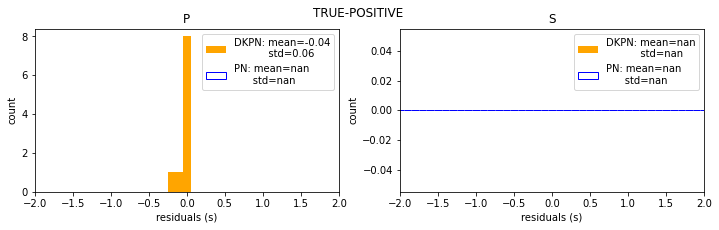

In [13]:
# CREATE A LIST OF UNIQUE INDEX FROM RANDOM ... AVOID DUPLICATES
if GORANDOM:
    rng = np.random.default_rng(seed=RANDOM_SEED)
    rnidx = rng.choice(np.arange(TEST_SAMPLES), size=TEST_SAMPLES, replace=False)
# --------------------------------------------------------------

do_stats_on = [#(dev_generator_dkpn, "DEV_DKPN", "DEV_PN"),
               (test_generator_dkpn, "TEST_DKPN", "TEST_PN")
                   ]

dkpn_p_pick_residuals, dkpn_s_pick_residuals = [], []
pn_p_pick_residuals, pn_s_pick_residuals = [], []


for (DKPN_gen, DKPN_gen_name, PN_gen_name) in  do_stats_on:
    
    print("Working with:  %s + %s" % (DKPN_gen_name, PN_gen_name))
    DKPN_stats_dict_P, DKPN_stats_dict_S = EV.__reset_stats_dict__(), EV.__reset_stats_dict__()
    PN_stats_dict_P, PN_stats_dict_S = EV.__reset_stats_dict__(), EV.__reset_stats_dict__()

    figureidx = 0
    
    for xx in tqdm(range(TEST_SAMPLES)):

        if GORANDOM:
            DKPN_sample = DKPN_gen[rnidx[xx]]
        else:
            DKPN_sample = DKPN_gen[xx]

        # Create equal window for PN (stored in Xorig of DKPN, but we must remove the 400 sample stab.)
        PN_sample = {}
        PN_sample["X"] = DKPN_sample["Xorig"][:, 400:] # <-- To remove the FP stabilization
        PN_sample["y"] = DKPN_sample["y"]
            
        # ----------------- Do PREDICTIONS
        # print("... Doing Predictions!")
        with torch.no_grad():
            DKPN_pred = mydkpn(torch.tensor(DKPN_sample["X"], device=mydkpn.device).unsqueeze(0))  # Add a fake batch dimension
            DKPN_pred = DKPN_pred[0].cpu().numpy()

        with torch.no_grad():
            PN_pred = mypn(torch.tensor(PN_sample["X"], device=mydkpn.device).unsqueeze(0))  # Add a fake batch dimension
            PN_pred = PN_pred[0].cpu().numpy()


        # ----------------- Do STATISTICS DKPN
        # print("... Doing Statistics on DKPN")
        # P
        (DKPN_P_picks_model, DKPN_P_widths_model) = EV.extract_picks(DKPN_pred[0], 
                                                                  smooth=True,
                                                                  thr=PICKTHRESHOLD_P)
        (DKPN_P_picks_label, DKPN_P_widths_label) = EV.extract_picks(DKPN_sample["y"][0], 
                                                                  smooth=True,
                                                                  thr=PICKTHRESHOLD_P)
        (DKPN_stats_dict_P, DKPN_residual_TP_P) = EV.compare_picks(
                                          DKPN_P_picks_model, 
                                          DKPN_P_picks_label, 
                                          DKPN_stats_dict_P)
        # S
        (DKPN_S_picks_model, DKPN_S_widths_model) = EV.extract_picks(DKPN_pred[1], 
                                                                  smooth=True,
                                                                  thr=PICKTHRESHOLD_S)
        (DKPN_S_picks_label, DKPN_S_widths_label) = EV.extract_picks(DKPN_sample["y"][1], 
                                                                  smooth=True,
                                                                  thr=PICKTHRESHOLD_S)
        (DKPN_stats_dict_S, DKPN_residual_TP_S) = EV.compare_picks(
                                          DKPN_S_picks_model, 
                                          DKPN_S_picks_label, 
                                          DKPN_stats_dict_S)

        dkpn_p_pick_residuals.extend(DKPN_residual_TP_P)
        dkpn_s_pick_residuals.extend(DKPN_residual_TP_S)


        # ----------------- Do STATISTICS PN
        # print("... Doing Statistics on PHASENET")
        # P
        (PN_P_picks_model, PN_P_widths_model) = EV.extract_picks(PN_pred[0], 
                                                              smooth=True,
                                                              thr=PICKTHRESHOLD_P)
        (PN_P_picks_label, PN_P_widths_label) = EV.extract_picks(PN_sample["y"][0], 
                                                              smooth=True,
                                                              thr=PICKTHRESHOLD_P)
        (PN_stats_dict_P, PN_residual_TP_P) = EV.compare_picks(
                                        PN_P_picks_model, 
                                        PN_P_picks_label, 
                                        PN_stats_dict_P)
        # S
        (PN_S_picks_model, PN_S_widths_model) = EV.extract_picks(PN_pred[1], 
                                                              smooth=True,
                                                              thr=PICKTHRESHOLD_S)  
        (PN_S_picks_label, PN_S_widths_label) = EV.extract_picks(PN_sample["y"][1], 
                                                              smooth=True,
                                                              thr=PICKTHRESHOLD_S)
        (PN_stats_dict_S, PN_residual_TP_S) = EV.compare_picks(
                                        PN_S_picks_model, 
                                        PN_S_picks_label,
                                        PN_stats_dict_S)

        pn_p_pick_residuals.extend(PN_residual_TP_P)
        pn_s_pick_residuals.extend(PN_residual_TP_S)


        # ----------------- Do PLOTS
        if PLOTS and (figureidx+1) <= NPLOTS:
            fig = EV.create_AL_plots(
                    PN_sample["X"],
                    PN_sample["y"],
                    DKPN_sample["X"],
                    PN_pred,
                    DKPN_pred,
                    PN_P_picks_label,    # The groundtruth IDX
                    PN_S_picks_label,    # The groundtruth IDX
                    PN_P_picks_model,    # The PN model picks IDX
                    PN_S_picks_model,    # The PN model picks IDX
                    DKPN_P_picks_model,  # The DKPN model picks IDX
                    DKPN_S_picks_model,  # The DKPN model picks IDX
                    save_path=str(
                        STORE_DIR_RESULTS / ("Prediction_Example_%s_%s_%d.pdf" % (
                                           DKPN_gen_name, PN_gen_name, figureidx)) ))
            # fig.show()
            plt.show()
        #
        figureidx += 1
    
    # Convert list of residuals, into numpy array of seconds
    dkpn_p_pick_residuals = np.array(dkpn_p_pick_residuals)*0.01
    dkpn_s_pick_residuals = np.array(dkpn_s_pick_residuals)*0.01
    pn_p_pick_residuals = np.array(pn_p_pick_residuals)*0.01
    pn_s_pick_residuals = np.array(pn_s_pick_residuals)*0.01

    # ------------------------------------------
    # ------- FINAL STATISTICS ON DKPN
    (DKPN_P_f1, DKPN_P_precision, DKPN_P_recall) = EV.calculate_scores(DKPN_stats_dict_P)
    (DKPN_S_f1, DKPN_S_precision, DKPN_S_recall) = EV.calculate_scores(DKPN_stats_dict_S)

    with open(str(STORE_DIR_RESULTS / ("SCORES_%s.txt" % DKPN_gen_name)), "w") as OUT:
        OUT.write(("samples:  %d"+os.linesep*2) % TEST_SAMPLES)
        for vv, kk in DKPN_stats_dict_P.items():
            OUT.write(("%5s:  %7d"+os.linesep) % (vv, kk))
        OUT.write(os.linesep)
        OUT.write(("P_f1:         %4.2f"+os.linesep) % DKPN_P_f1)
        OUT.write(("P_precision:  %4.2f"+os.linesep) % DKPN_P_precision)
        OUT.write(("P_recall:     %4.2f"+os.linesep*2) % DKPN_P_recall)
        #
        for vv, kk in DKPN_stats_dict_S.items():
            OUT.write(("%5s:  %7d"+os.linesep) % (vv, kk))
        OUT.write(os.linesep)
        OUT.write(("S_f1:         %4.2f"+os.linesep) % DKPN_S_f1)
        OUT.write(("S_precision:  %4.2f"+os.linesep) % DKPN_S_precision)
        OUT.write(("S_recall:     %4.2f"+os.linesep*2) % DKPN_S_recall)

    # CREATE dictionary to disk
    res_dict = {}
    res_dict['samples'] = TEST_SAMPLES
    #
    res_dict.update({"P_"+kk: vv for kk, vv in DKPN_stats_dict_P.items()})
    res_dict["P_f1"] = DKPN_P_f1
    res_dict["P_precision"] = DKPN_P_precision
    res_dict["P_recall"] = DKPN_P_recall
    #
    res_dict.update({"S_"+kk: vv for kk, vv in DKPN_stats_dict_S.items()})
    res_dict["S_f1"] = DKPN_S_f1
    res_dict["S_precision"] = DKPN_S_precision
    res_dict["S_recall"] = DKPN_S_recall

    # SAVE dictionary to disk
    with open(str(STORE_DIR_RESULTS / 'results_DKPN.pickle'), 'wb') as file:
        pickle.dump(res_dict, file)

    # ------------------------------------------
    # ------- FINAL STATISTICS ON PN
    (PN_P_f1, PN_P_precision, PN_P_recall) = EV.calculate_scores(PN_stats_dict_P)
    (PN_S_f1, PN_S_precision, PN_S_recall) = EV.calculate_scores(PN_stats_dict_S)

    with open(str(STORE_DIR_RESULTS / ("SCORES_%s.txt" % PN_gen_name)), "w") as OUT:
        OUT.write(("samples:  %d"+os.linesep*2) % TEST_SAMPLES)
        for vv, kk in PN_stats_dict_P.items():
            OUT.write(("%5s:  %7d"+os.linesep) % (vv, kk))
        OUT.write(os.linesep)
        OUT.write(("P_f1:         %4.2f"+os.linesep) % PN_P_f1)
        OUT.write(("P_precision:  %4.2f"+os.linesep) % PN_P_precision)
        OUT.write(("P_recall:     %4.2f"+os.linesep*2) % PN_P_recall)
        #
        for vv, kk in PN_stats_dict_S.items():
            OUT.write(("%5s:  %7d"+os.linesep) % (vv, kk))
        OUT.write(os.linesep)
        OUT.write(("S_f1:         %4.2f"+os.linesep) % PN_S_f1)
        OUT.write(("S_precision:  %4.2f"+os.linesep) % PN_S_precision)
        OUT.write(("S_recall:     %4.2f"+os.linesep*2) % PN_S_recall)

    # CREATE dictionary to disk
    res_dict = {}
    res_dict['samples'] = TEST_SAMPLES
    #
    res_dict.update({"P_"+kk: vv for kk, vv in PN_stats_dict_P.items()})
    res_dict["P_f1"] = PN_P_f1
    res_dict["P_precision"] = PN_P_precision
    res_dict["P_recall"] = PN_P_recall
    #
    res_dict.update({"S_"+kk: vv for kk, vv in PN_stats_dict_S.items()})
    res_dict["S_f1"] = PN_S_f1
    res_dict["S_precision"] = PN_S_precision
    res_dict["S_recall"] = PN_S_recall

    # SAVE dictionary to disk
    with open(str(STORE_DIR_RESULTS / 'results_PN.pickle'), 'wb') as file:
        pickle.dump(res_dict, file)


    # =============================================================================
    fig = EV.create_residuals_plot_compare(dkpn_p_pick_residuals, dkpn_s_pick_residuals, 
                                           pn_p_pick_residuals, pn_s_pick_residuals, 
                                           binwidth=0.1,
                                           save_path=str(STORE_DIR_RESULTS / "RESIDUALS_P_S_comparison_DKPN_PN.pdf"))
    fig.show()

In [7]:
# Load the dictionary from disk
with open(str(STORE_DIR_RESULTS / 'results_DKPN.pickle'), 'rb') as file:
    loaded_data = pickle.load(file)

In [8]:
loaded_data

{'samples': 2000,
 'P_TOTAL': 1737,
 'P_TP': 1572,
 'P_FP': 135,
 'P_FN': 165,
 'P_f1': 0.9128914855707958,
 'P_precision': 0.9209138834675372,
 'P_recall': 0.9050086350575655,
 'S_TOTAL': 1399,
 'S_TP': 1173,
 'S_FP': 95,
 'S_FN': 226,
 'S_f1': 0.8796395455413422,
 'S_precision': 0.9250788636237548,
 'S_recall': 0.8384560394292665}